# ReadtheDocs Retrieval Augmented Generation (RAG)

In this notebook, we are going to use Milvus documentation pages to create a chatbot about our product.  The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.

Many RAG demos use OpenAI for the Embedding Model and ChatGPT for the Generative AI model.  **In this notebook, we will demo a fully open source RAG stack.**

Using open-source Q&A with retrieval saves money since we make free calls to our own data almost all the time - retrieval, evaluation, and development iterations.

<div>
<img src="../../../images/rag_image.png" width="80%"/>
</div>

Let's get started!

In [1]:
# For colab install these libraries in this order:
# !python -m pip install torch transformers sentence-transformers langchain
# !python -m pip install -U pymilvus
# !python -m pip install unstructured openai tqdm numpy ipykernel 
# !python -m pip install ragas datasets

In [2]:
# Import common libraries.
import sys, os, time, pprint

In [3]:
# Function to remove newlines and double spaces from a string.
def clean_text(text):
    clean_text = text.replace("\n\n", " ")\
                     .replace("\n", " ")\
                     .replace("<br><br>", " ")\
                     .replace("<br /><br />", " ")
    
    # Remove extra whitespace.
    clean_text = ' '.join(clean_text.split())
    return clean_text

import numpy as np
import matplotlib.pyplot as plt

# Function to inspect chunk lengths in matplotlit.
def plot_chunk_lengths(chunked_docs, title_keyword):
    # Get chunk lengths.
    lengths = [len(doc.page_content) for doc in chunked_docs]

    # Mean, median lengths.
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)

    # Assemble the title.
    title = f"Chunk Lengths from {title_keyword} Chunking"

    # Plot the lengths.
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.plot(lengths, marker='o')  # Plot lengths with circle markers
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Document Index')  # X-axis label
    plt.ylabel('Length')  # Y-axis label
    plt.grid(True)  # Show grid

    # Add a horizontal line at mean and median length
    plt.axhline(y=mean_length, color='g', linestyle='-')
    plt.axhline(y=median_length, color='r', linestyle='-')
    plt.text(len(lengths)-1, mean_length, f'mean = {mean_length:.0f}', va='center', ha='left', backgroundcolor='w', fontsize=12)
    plt.text(0, median_length, f'median = {median_length:.0f}', va='center', ha='right', backgroundcolor='w', fontsize=12)

    plt.show()  # Display the plot

## Download Data

The data used in this notebook is Milvus documentation web pages.

The code block below downloads all the web pages into a local directory called `rtdocs`.  

I've already uploaded the `rtdocs` data folder to github, so you should see it if you cloned my repo.

In [4]:
# # UNCOMMENT TO DOWNLOAD THE DOCS.

# # !pip install -U langchain
# from langchain_community.document_loaders import RecursiveUrlLoader

# DOCS_PAGE="https://milvus.io/docs/"

# loader = RecursiveUrlLoader(DOCS_PAGE)
# docs = loader.load()

# num_documents = len(docs)
# print(f"loaded {num_documents} documents")

# # # Subset docs for faster testing
# # docs = docs[5:7].copy()
# # num_documents = len(docs)
# # print(f"testing with {num_documents} documents")

# # Print the type of the docs.
# print(type(docs))
# print(type(docs[0]))

# docs[0].page_content[:500]

# # UNCOMMENT TO SAVE THE DOCS LOCALLY.
# OUTPUT_DIR = "../../RAG/rtdocs_new/"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Convert each doc to HTML and save to the specified directory
# for doc in docs:
#     # Extract file name
#     filename = doc.metadata['source'].split('/')[-1].replace(".md", ".html")
    
#     # Check that filename is not empty
#     if filename:
#         with open(os.path.join(OUTPUT_DIR, filename), "w") as f:
#             f.write(doc.page_content)
#     else:
#         print("Filename is empty. Skipping this doc.")
#         pprint.pprint(doc.metadata)
#         pprint.pprint(doc.page_content[:500])

In [5]:
# From raw docs

# UNCOMMENT TO READ THE DOCS FROM A LOCAL DIRECTORY.

# Read docs into LangChain
# !pip install -U langchain
# !pip install unstructured
from langchain.document_loaders import DirectoryLoader

# Load HTML files from a local directory
path = "../../RAG/rtdocs_new/"
global_pattern = '*.html'
loader = DirectoryLoader(path=path, glob=global_pattern)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")

# # Subset docs for faster testing
# docs = docs[5:7].copy()
# num_documents = len(docs)
# print(f"testing with {num_documents} documents")

# Print the type of the docs.
print(type(docs))
print(type(docs[0]))

docs[0].page_content[:500]

loaded 22 documents
<class 'list'>
<class 'langchain_core.documents.base.Document'>


'Why Milvus\n\nDocs\n\nTutorials\n\nTools\n\nBlog\n\nCommunity\n\nStars0\n\nTry Managed Milvus FREE\n\nSearch\n\nHome\n\nv2.4.x\n\nAbout Milvus\n\nGet StartedPrerequisitesInstall MilvusInstall SDKsQuickstart\n\nConcepts\n\nUser Guide\n\nModels\n\nAdministration Guide\n\nTools\n\nIntegrations\n\nExample Applications\n\nFAQs\n\nAPI reference\n\nQuickstart\n\nThis guide explains how to connect to your Milvus cluster and performs CRUD operations in minutes\n\nBefore you start\n\nYou have installed Milvus standalone or Milvus cluster.\n\nYou have insta'

## Load the Embedding Model checkpoint and use it to create vector embeddings

#### What are Embeddings?

Check out [this blog](https://zilliz.com/glossary/vector-embeddings) for an introduction to embeddings.  

An excellent place to start is by selecting an embedding model from the [HuggingFace MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.  

Milvus (and Zilliz) only supports tested embedding models that are **not overfit**!

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

# Use an embedding model.
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
embed_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
EMBEDDING_DIM = embed_model.dict()['client'].get_sentence_embedding_dimension()
print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


MODEL: BAAI/bge-large-en-v1.5, EMBEDDING_DIM: 1024


In [7]:
# !python -m pip install --upgrade langchain_openai

In [8]:
# from langchain_openai.embeddings import OpenAIEmbeddings

# # 1. Get your API key: https://platform.openai.com/api-keys
# # 2. Save your api key in env variable.
# # https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

# # 3. OpenAI embedding model name, `text-embedding-3-large` or `ext-embedding-3-small`.
# # release notes: https://openai.com/index/new-embedding-models-and-api-updates/
# model_name = "text-embedding-3-small"
# EMBEDDING_DIM = 512

# model_kwargs = {'device': 'cpu'}
# embed_model = OpenAIEmbeddings(
#     model=model_name,
#     dimensions=EMBEDDING_DIM,
#     model_kwargs=model_kwargs
# )
# print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

## Recursive Character chunking 

In [9]:
import pprint, time
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_milvus import Milvus

CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to use to create smaller (child) chunks
# Default splitters: https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842
child_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    length_function = len,  # use built-in Python len function
    # separators=["\n\n"],  # split at end of paragraphs
    separators = ["\n\n", "\n", " ", ". ", ""], # defaults
)

# Child docs directly from raw docs
sub_docs = child_text_splitter.split_documents(docs)

# Clean the parent docs.
for doc in sub_docs:
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")

# Inspect chunk lengths
print(f"{len(docs)} docs split into {len(sub_docs)} child documents.")
print(sub_docs[0].page_content[:200])
pprint.pprint(sub_docs[0].metadata)

chunk_size: 512, chunk_overlap: 51.0
22 docs split into 427 child documents.
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Ad
{'source': 'https://milvus.io/docs/quickstart.md'}


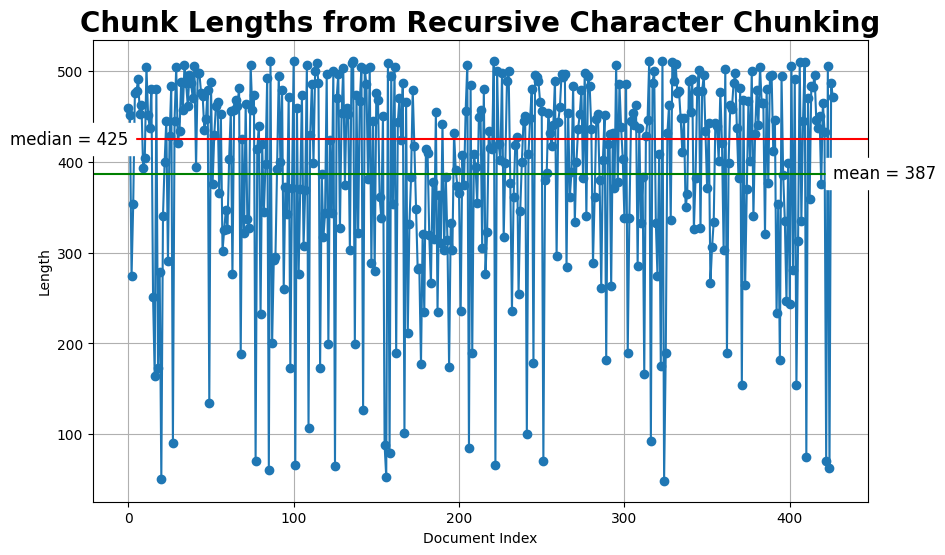

In [10]:
# Inspect chunk lengths
plot_chunk_lengths(sub_docs, 'Recursive Character')

In [11]:
# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"
start_time = time.time()
vectorstore = Milvus.from_documents(
    collection_name=COLLECTION_NAME,
    documents=sub_docs,
    embedding=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    # Override LangChain default values for Milvus.
    consistency_level="Eventually",
    # auto_id=True,
    drop_old=True,
    index_params = {
        "metric_type": "COSINE",
        "index_type": "AUTOINDEX",
        "params": {},}
)
end_time = time.time()
print(f"Created Milvus collection from {len(sub_docs)} docs in {end_time - start_time:.2f} seconds")

Created Milvus collection from 427 docs in 36.02 seconds


In [12]:
# Delete the Milvus collection and vectorstore.
# del vectorstore

## Small-to-big Chunking without HTML chunking

In [13]:
# !python -m pip install lxml
from langchain_milvus import Milvus
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time, pprint, uuid
import numpy as np
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Create doc storage for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"
vectorstore = Milvus(
    collection_name=COLLECTION_NAME,
    embedding_function=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    auto_id=True,
    # Set to True to drop the existing collection if it exists.
    drop_old=True,
)

# The MultiVectorRetriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

In [14]:
PARENT_CHUNK_SIZE = 1586

# The splitter to use to create bigger (parent) chunks
parent_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=PARENT_CHUNK_SIZE,
    length_function = len,  # use built-in Python len function
    # separators=["\n\n"],  # split at end of paragraphs
)

# Parent docs directly from raw docs
parent_docs = parent_text_splitter.split_documents(docs)
doc_ids = [str(uuid.uuid4()) for _ in parent_docs]

# Clean the parent docs.
for doc_id, doc in zip(doc_ids, parent_docs):
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")
    doc.metadata = {
        **doc.metadata,
        "doc_index": doc_id
    }

# Inspect chunk lengths
print(f"{len(docs)} docs split into {len(parent_docs)} parent documents.")
print(parent_docs[0].page_content[:200])
pprint.pprint(parent_docs[0].metadata)

22 docs split into 130 parent documents.
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Ad
{'doc_index': '9511a773-fdb6-4eb1-bc40-f363bfd0da2f',
 'source': 'https://milvus.io/docs/quickstart.md'}


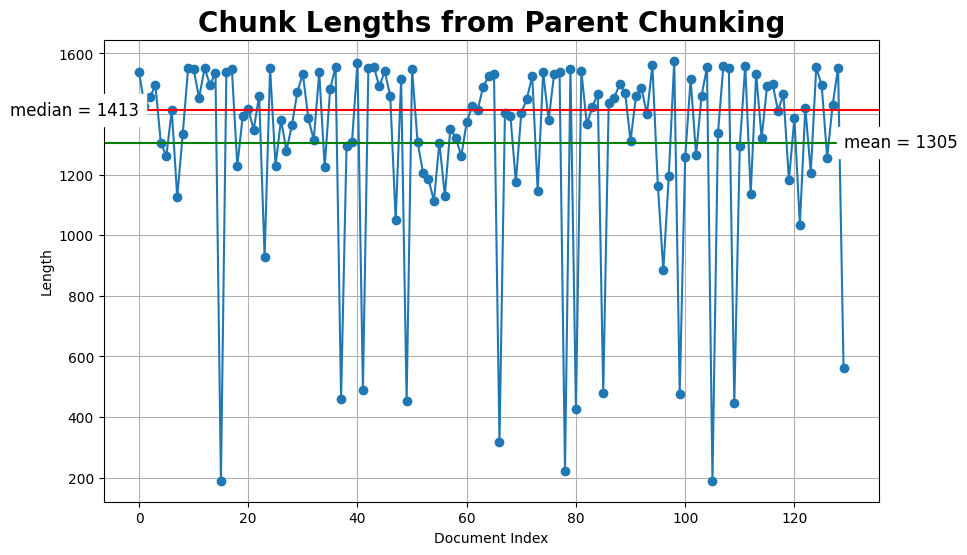

In [15]:
# Inspect chunk lengths
plot_chunk_lengths(parent_docs, 'Parent')

In [16]:
CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to use to create smaller (child) chunks
# Default splitters: https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842
child_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    length_function = len,  # use built-in Python len function
    # separators=["\n\n"],  # split at end of paragraphs
    separators = ["\n\n", "\n", " ", ". ", ""], # defaults
)

# Generate the "sub" documents by splitting the original documents. 
# Store the doc_id in the metadata of the corresponding Document object.
sub_docs = child_text_splitter.split_documents(parent_docs)

# Inspect chunk lengths
print(f"{len(parent_docs)} parent docs split into {len(sub_docs)} child docs.")
print(sub_docs[4].page_content[:200])
pprint.pprint(sub_docs[4].metadata)

chunk_size: 512, chunk_overlap: 51.0
130 parent docs split into 424 child docs.
If you have enabled TLS on your Milvus instance, you should provide certificate file paths when initiating MilvusClient. For information on how to enable TLS, refer to Encryption in Transit. Create a 
{'doc_index': '32e3dba2-5492-4702-88cd-a72f4574e817',
 'source': 'https://milvus.io/docs/quickstart.md'}


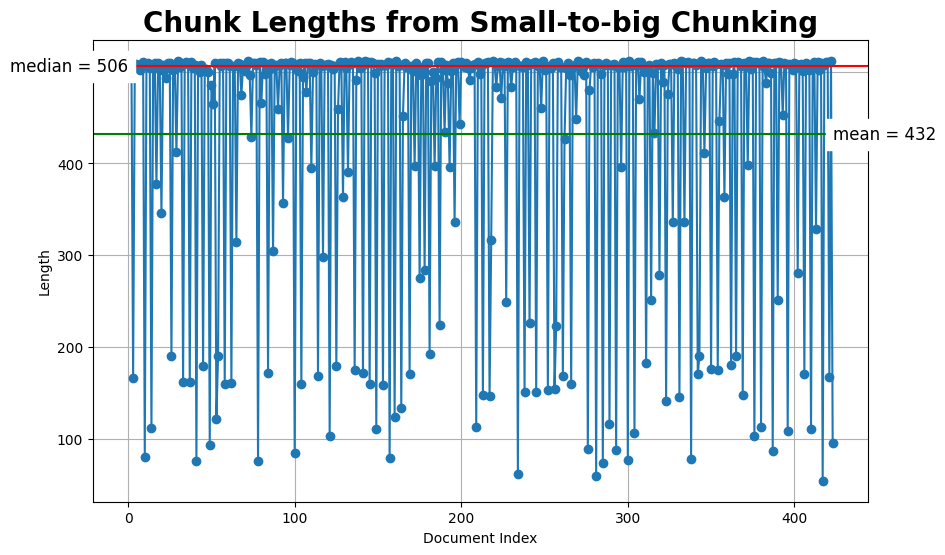

In [17]:
# Inspect chunk lengths
plot_chunk_lengths(sub_docs, 'Small-to-big')

In [18]:
# Index the documents in the document store.
start_time = time.time()
retriever.docstore.mset(list(zip(doc_ids, parent_docs)))
print(f"Indexed {len(parent_docs)} parent documents in {time.time()-start_time:.2f} seconds and ")

# Index the documents in the vector store.
batch_size = 300
total_docs = len(sub_docs)
# Calculate the number of batches needed
batches = (total_docs + batch_size - 1) // batch_size
start_time = time.time()
for i in range(batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, total_docs)
    batch = sub_docs[batch_start:batch_end]
    retriever.vectorstore.add_documents(batch)

print(f"Indexed a total of {total_docs} child documents in {time.time()-start_time:.2f} seconds")

# Indexed 507 documents in 56.15 seconds.

Indexed 130 parent documents in 0.00 seconds and 
Indexed a total of 424 child documents in 36.56 seconds


In [19]:
# Delete the Milvus collection and doc store.
# del vectorstore, retriever, store

## Semantic Chunking using LangChain

This chunker works by determining when to "break" apart sentences. This is done by calculating cosine distances between adjacent sentences. Looking across all these cosine distances, look for outlier distances past some threshold.  These outlier distances determine when chunks are split.

There are a few ways to determine what that threshold is, which are controlled by the breakpoint_threshold_type kwarg.

- `percentile` (default) — In this method, any distances greater than X percentile is split into a chunk.

- `standard_deviation` — In this method, any difference greater than X standard deviations is split.

- `interquartile` — In this method, the interquartile distance is used to split chunks.

- See Semantic Chunking [docs](https://python.langchain.com/v0.2/docs/how_to/semantic-chunker/#standard-deviation) and [api](https://api.python.langchain.com/en/latest/text_splitter/langchain_experimental.text_splitter.SemanticChunker.html).

In [20]:
# !python -m pip install langchain_experimental

In [21]:
from langchain_experimental.text_splitter import SemanticChunker

doc_ids = [str(uuid.uuid4()) for _ in docs]

semantic_docs = []
for doc in docs:
    # Extract and clean document content.
    cleaned_content = clean_text(doc.page_content)

    # Initialize the SemanticChunker with the embedding model.
    text_splitter = SemanticChunker(embed_model)
    semantic_list = text_splitter.create_documents([cleaned_content])

    # Add source metadata to each chunk.
    for chunk in semantic_list:
        chunk.metadata["source"] = doc.metadata["source"]
        chunk.metadata["source"] = chunk.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")
        chunk.metadata['doc_index'] = doc_id

    # Append the list of semantic chunks to semantic_docs.
    semantic_docs.extend(semantic_list)

# Inspect chunk lengths
print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")
pprint.pprint(semantic_docs[0].page_content[:200])
pprint.pprint(semantic_docs[0].metadata)
# Created 87 semantic documents from 22.

Created 87 semantic documents from 22.
('Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus '
 'FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall '
 'MilvusInstall SDKsQuickstart Concepts User Guide Models Ad')
{'doc_index': 'f1754e61-07ea-44ed-a050-5fc994eadb83',
 'source': 'https://milvus.io/docs/quickstart.md'}


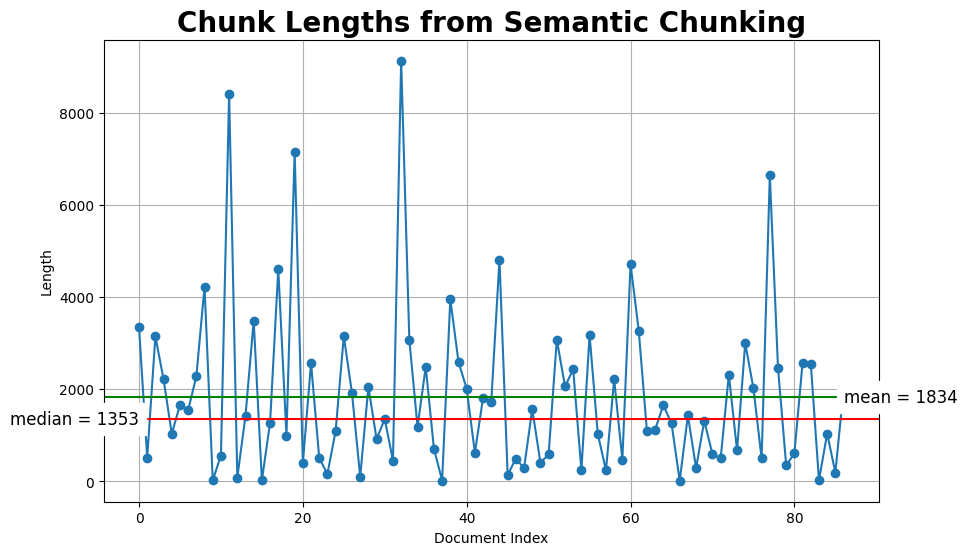

In [22]:
# Inspect chunk lengths
plot_chunk_lengths(semantic_docs, 'Semantic')

In [23]:
# # Use Percentile to determine breakpoints.
# text_splitter = SemanticChunker(
#     embed_model, 
#     breakpoint_threshold_type="percentile",
#     breakpoint_threshold_amount=0.99
# )

# semantic_docs = text_splitter.create_documents([all_page_contents])
# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")

# # Too many!
# # Created 1138 semantic documents from 22.

In [24]:
# # Use Standard Deviation to determine breakpoints.
# text_splitter = SemanticChunker(
#     embed_model, 
#     breakpoint_threshold_type="standard_deviation",
#     breakpoint_threshold_amount=0.80
# )
# semantic_docs = text_splitter.create_documents([all_page_contents])

# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")
# print(", ".join(str(len(doc.page_content)) for doc in semantic_docs))
# pprint.pprint(semantic_docs[0].page_content)

# # Created 195 semantic documents from 22.

In [25]:
# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"
start_time = time.time()
vectorstore = Milvus.from_documents(
    collection_name=COLLECTION_NAME,
    documents=semantic_docs,
    embedding=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    # Override LangChain default values for Milvus.
    consistency_level="Eventually",
    # auto_id=True,
    drop_old=True,
    index_params = {
        "metric_type": "COSINE",
        "index_type": "AUTOINDEX",
        "params": {},}
)
end_time = time.time()
print(f"Created Milvus collection from {len(semantic_docs)} docs in {end_time - start_time:.2f} seconds")

Created Milvus collection from 87 docs in 22.63 seconds


In [26]:
# Delete the Milvus collection and vectorstore.
# del vectorstore

## HTML Chunking using LangChain

Before embedding, it is necessary to decide your chunk strategy, chunk size, and chunk overlap.  This section uses:
- **Strategy** = Use markdown header hierarchies.  Keep markdown sections together unless they are too long.
- **Chunk size** = Use the embedding model's parameter `MAX_SEQ_LENGTH`
- **Overlap** = Rule-of-thumb 10-15%
- **Function** = 
  - Langchain's `HTMLHeaderTextSplitter` to split markdown sections.
  - Langchain's `RecursiveCharacterTextSplitter` to split up long reviews recursively.


Notice below, each chunk is grounded with the document source page.  <br>
In addition, header titles are kept together with the chunk of markdown text.

In [27]:
# !python -m pip install lxml
from langchain.text_splitter import HTMLHeaderTextSplitter, RecursiveCharacterTextSplitter
import uuid, re

doc_ids = [str(uuid.uuid4()) for _ in docs]

# Define the headers to split on for the HTMLHeaderTextSplitter
headers_to_split_on = [
    ("<h1>", "Header 1"),
    ("<h2>", "Header 2"),
    ("<h3>", "Header 3"),
]
# Create an instance of the HTMLHeaderTextSplitter
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Construct a regex pattern to match any of the specified headers
pattern = '|'.join(re.escape(header[0]) for header in headers_to_split_on)
# More complex pattern to match opening, closing, and self-closing tags.
pattern = r"<h[1-3](?: [^>]*)?>|</h[1-3]>|<h[1-3](?: [^>]*)?/>"
print("Pattern for splitting:", pattern)

# Function to remove all HTML tags
def remove_html_tags(text):
    return re.sub(r"<[^>]+>", "", text)

# Split the HTML text using the HTMLHeaderTextSplitter.
html_docs = []
for doc_id, doc in zip(doc_ids, docs):

    # Grab the headers
    new_text = doc.page_content
    new_text = clean_text(new_text).replace('\n', ' ')
    html_split_list = re.split(pattern, new_text)
    # print(html_split_list[0])
    # Remove HTML tags from each extracted header text
    html_split_list = [remove_html_tags(header) for header in html_split_list]
    # print(html_split_list[0])
    # print(f"Split into {len(html_split_list)} parts.")

    # Split the text into chunks using the HTMLHeaderTextSplitter.
    splits = html_splitter.split_text(doc.page_content)

    for split in splits:

        # Clean the text.
        split.page_content = clean_text(split.page_content)

        # Assemble the metadata.
        metadata = {}
        # Handle exception if h1 does not exist.
        try:
            header_value1 = html_split_list[1].strip()[:25]
            metadata["h1"] = header_value1
            # print(f"header_name: h1, header_value: {header_value1}")
        except:
            pass
        # Handle exception if h2 does not exist.
        try:
            header_value2 = html_split_list[2].strip()[:25]
            if len(header_value2) <= 0:
                header_value2 = html_split_list[3].strip()[:25]
            metadata["h2"] = header_value2
            # print(f"header_name: h2, header_value: {header_value2}")
        except:
            pass
        # Handle exception if h2 does not exist.
        try:
            header_value3 = html_split_list[3].strip()[:25]
            if (len(header_value3) <= 0 or header_value3 == header_value2):
                header_value3 = html_split_list[4].strip()[:25]
            if header_value3 == header_value2:
                header_value3 = html_split_list[5].strip()[:25]
            metadata["h3"] = header_value3
            # print(f"header_name: h3, header_value: {header_value3}")
        except:
            pass
        split.metadata = {
            **metadata,
            "source": doc.metadata["source"]\
                .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
                .replace(".html", ".md"),
            'doc_index': doc_id
        }
    html_docs.extend(splits)

# Inspect chunk lengths
print(f"docs: {len(docs)}, split into {len(html_docs)} html chunks.")
print(html_docs[4].page_content[:200])
print(html_docs[4].metadata)

Pattern for splitting: <h[1-3](?: [^>]*)?>|</h[1-3]>|<h[1-3](?: [^>]*)?/>
docs: 22, split into 22 html chunks.
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get Started Concepts User Guide Models Administration GuideDeploymentConfigurationManage D
{'source': 'https://milvus.io/docs/monitor_overview.md', 'doc_index': 'b98ce724-49f4-48c2-9ea9-8b23d91fe1e7'}


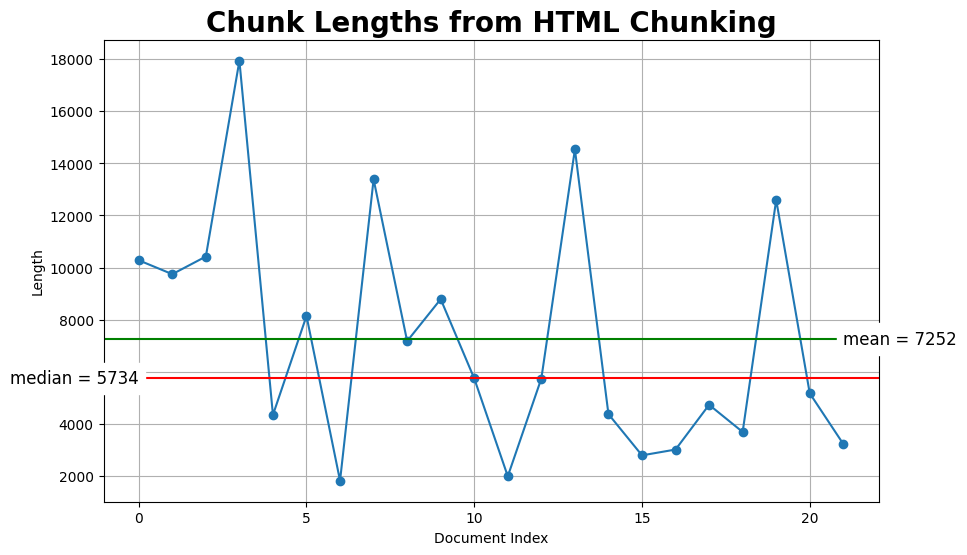

In [28]:
# Inspect chunk lengths
plot_chunk_lengths(html_docs, 'HTML')

## Small-to-Big from HTML Chunks

Often times it can be useful to retrieve larger chunks of information, but embed smaller chunks. This allows for embeddings to capture the semantic meaning as closely as possible, but for as much context as possible to be passed downstream. Note that this is what the ParentDocumentRetriever does. Here we show what is going on under the hood.

> - The vector store indexes and searches embeddings of the smallest (sub) documents.  
> - The document store houses the "parent" documents and associates them with an identifier.

- See MultiVectorRetriever [api](https://api.python.langchain.com/en/latest/retrievers/langchain.retrievers.multi_vector.MultiVectorRetriever.html).
- See ParentDocumentRetriever [docs](https://python.langchain.com/v0.2/docs/how_to/multi_vector/#smaller-chunks) and [api](https://api.python.langchain.com/en/latest/retrievers/langchain.retrievers.parent_document_retriever.ParentDocumentRetriever.html).

In [29]:
# !python -m pip install lxml
from langchain_milvus import Milvus
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time, pprint, uuid
import numpy as np
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Create doc storage for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"
vectorstore = Milvus(
    collection_name=COLLECTION_NAME,
    embedding_function=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    auto_id=True,
    # Set to True to drop the existing collection if it exists.
    drop_old=True,
)

# The MultiVectorRetriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

In [30]:
PARENT_CHUNK_SIZE = 1586

# The splitter to use to create bigger (parent) chunks
parent_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=PARENT_CHUNK_SIZE,
    length_function = len,  # use built-in Python len function
)
# From HTML chunks.
parent_docs = parent_text_splitter.split_documents(html_docs)

# Inspect chunk lengths
print(f"{len(html_docs)} docs split into {len(parent_docs)} parent documents.")
print(parent_docs[0].page_content[:200])
pprint.pprint(parent_docs[0].metadata)

22 docs split into 124 parent documents.
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Ad
{'doc_index': '792f9fa5-5ac9-4749-9778-18aaa9f4adb1',
 'source': 'https://milvus.io/docs/quickstart.md'}


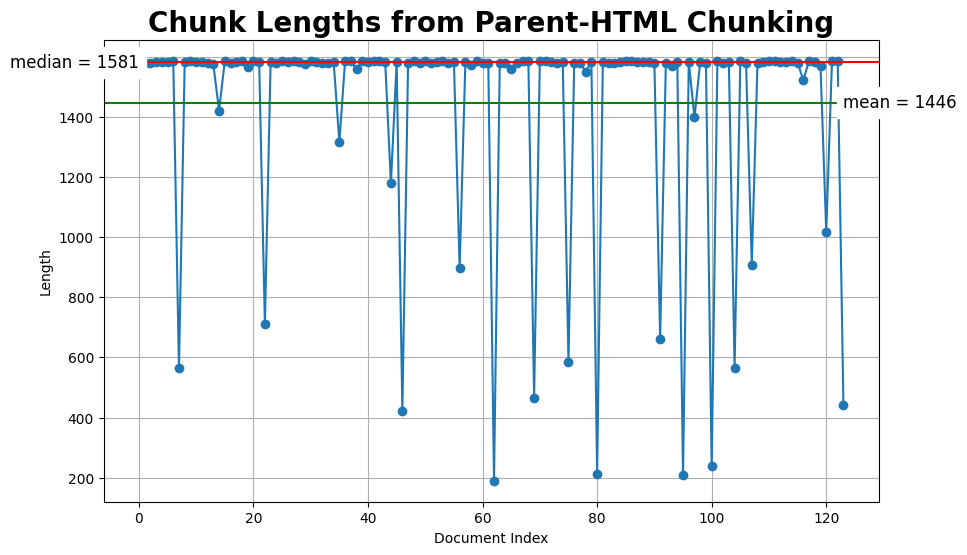

In [31]:
# Inspect chunk lengths
plot_chunk_lengths(parent_docs, 'Parent-HTML')

In [32]:
CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to use to create smaller (child) chunks
# Default splitters: https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842
child_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    length_function = len,  # use built-in Python len function
    # separators=["\n\n"],  # split at end of paragraphs
    separators = ["\n\n", "\n", " ", ". ", ""], # defaults
)

# Generate the "sub" documents by splitting the original documents. 
# Store the doc_id in the metadata of the corresponding Document object.
sub_docs = child_text_splitter.split_documents(parent_docs)

# Inspect chunk lengths
print(f"{len(parent_docs)} parent docs split into {len(sub_docs)} child docs.")
print(sub_docs[4].page_content[:200])
pprint.pprint(sub_docs[4].metadata)

chunk_size: 512, chunk_overlap: 51.0
124 parent docs split into 456 child docs.
using the default username and password, set token to root:Milvus. For information on how to enable authentication, refer to Authenticate User Access. If you have enabled TLS on your Milvus instance, 
{'doc_index': '792f9fa5-5ac9-4749-9778-18aaa9f4adb1',
 'source': 'https://milvus.io/docs/quickstart.md'}


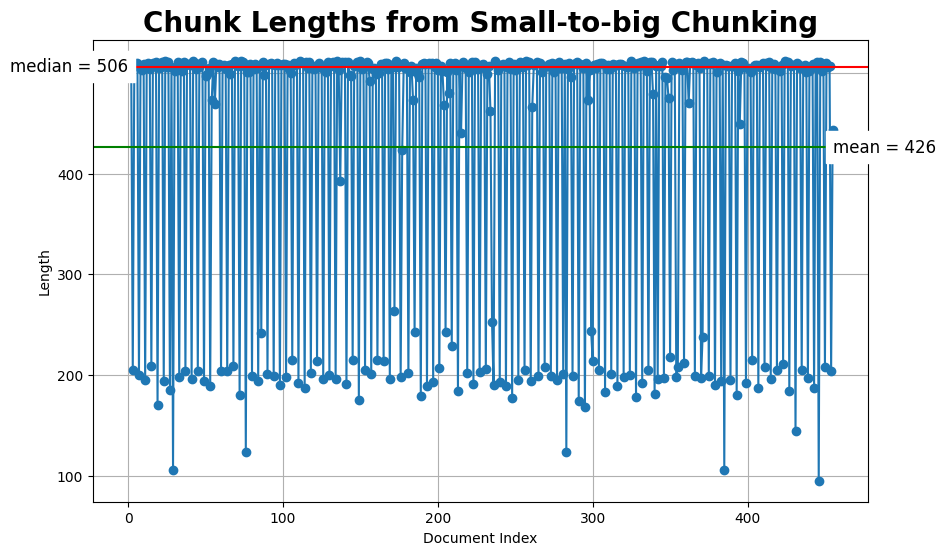

In [33]:
# Inspect chunk lengths
plot_chunk_lengths(sub_docs, 'Small-to-big')

In [34]:
# Index the documents in the document store.
start_time = time.time()
retriever.docstore.mset(list(zip(doc_ids, parent_docs)))
print(f"Indexed {len(parent_docs)} parent documents in {time.time()-start_time:.2f} seconds and ")

# Index the documents in the vector store.
batch_size = 300
total_docs = len(sub_docs)
# Calculate the number of batches needed
batches = (total_docs + batch_size - 1) // batch_size
start_time = time.time()
for i in range(batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, total_docs)
    batch = sub_docs[batch_start:batch_end]
    retriever.vectorstore.add_documents(batch)

print(f"Indexed a total of {total_docs} child documents in {time.time()-start_time:.2f} seconds")

# Indexed 507 documents in 56.15 seconds.

Indexed 124 parent documents in 0.00 seconds and 
Indexed a total of 456 child documents in 42.31 seconds


In [35]:
# Delete the Milvus collection and doc store.
# del vectorstore, retriever, store

## Ask a question about your data

So far in this demo notebook: 
1. Your custom data has been mapped into a vector embedding space
2. Those vector embeddings have been saved into a vector database

Next, you can ask a question about your custom data!

💡 In LLM vocabulary:
> **Query** is the generic term for user questions.  
A query is a list of multiple individual questions, up to maybe 1000 different questions!

> **Question** usually refers to a single user question.  
In our example below, the user question is "What is AUTOINDEX in Milvus Client?"

> **Semantic Search** = very fast search of the entire knowledge base to find the `TOP_K` documentation chunks with the closest embeddings to the user's query.

💡 The same model should always be used for consistency for all the embeddings data and the query.

In [36]:
# Define a sample question about your data.
QUESTION1 = "What do the parameters for HNSW mean?"
QUESTION2 = "What are good default values for HNSW parameters with 25K vectors dim 1024?"
QUESTION3 = "What does nlist vs nprobe mean in ivf_flat?"
QUESTION4 = "What is the default AUTOINDEX index and vector field distance metric in Milvus?"

# In case you want to ask all the questions at once.
QUERY = [QUESTION1, QUESTION2, QUESTION3, QUESTION4]

# Inspect the length of one question.
QUERY_LENGTH = len(QUESTION2)
print(f"example query length: {QUERY_LENGTH}")

example query length: 75


In [37]:
# SELECT A PARTICULAR QUESTION TO ASK.

SAMPLE_QUESTION = QUESTION1

## Execute a vector search

Search Milvus using [PyMilvus API](https://milvus.io/docs/search.md).

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Traditional Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.

### Search using Semantic Chunks

In [38]:
# # Retrieve semantic chunks.
# TOP_K = 2
# semantic_retriever = vectorstore.as_retriever(search_kwargs={"k" : TOP_K})
# semantic_results = semantic_retriever.invoke(SAMPLE_QUESTION)

# print(len(semantic_results))

# # Print the retrieved chunk and metadata.
# contexts = []
# sources = []
# for semantic_result in semantic_results:
#     context = semantic_result.page_content
#     print(len(context))
#     print(f"chunk: {context[:200]}")
#     pprint.pprint(f"metadata: {semantic_result.metadata}")

#     # Keep a copy of all the contexts and sources.
#     context = semantic_result.page_content
#     contexts.append(context)
#     source = child_result.metadata['source']
#       if source not in sources:
#           sources.append(source)

# # Keep only 1st semantic chunk.

In [39]:
# # Separate all the unique sources together by comma.
# source_combined = sources[0]
# print(f"sources: {source_combined}")

# # Separate all the context together by space.
# contexts_combined = semantic_results[0].page_content

# print(f"Length long text to summarize: {len(contexts_combined)}")

### Search using Small-to-Big Chunks

In [40]:
# The vector store alone will retrieve small chunks:
TOP_K = 2
child_results = retriever.vectorstore.similarity_search(
    SAMPLE_QUESTION,
    k=TOP_K)

# Print the retrieved chunk and metadata.
# Append each unique context and source to a list.
contexts = []
sources = []
for child_result in child_results:
    context = child_result.page_content
    print(len(context))
    print(f"chunk: {context}")
    pprint.pprint(f"metadata: {child_result.metadata}")
    context = child_result.page_content
    contexts.append(context)
    source = child_result.metadata['source']
    if source not in sources:
        sources.append(source)

print(f"sources: {len(sources)}, {sources}")

511
chunk: node closest to the target in this layer, and then enters the next layer to begin another search. After multiple iterations, it can quickly approach the target position. In order to improve performance, HNSW limits the maximum degree of nodes on each layer of the graph to M. In addition, you can use efConstruction (when building index) or ef (when searching targets) to specify a search range. Index building parameters Parameter Description Range M M defines tha maximum number of outgoing connections in the
("metadata: {'source': 'https://milvus.io/docs/index.md', 'doc_index': "
 "'a2da5d8d-3334-4195-a0ad-645aae1abf81', 'pk': 450877142505097161}")
505
chunk: rate at the cost of increased search time. [1, 65535] 2 HNSW HNSW (Hierarchical Navigable Small World Graph) is a graph-based indexing algorithm. It builds a multi-layer navigation structure for an image according to certain rules. In this structure, the upper layers are more sparse and the distances between nodes are far

In [41]:
# # Whereas the retriever will return the larger parent document:
# parent_results = retriever.invoke(SAMPLE_QUESTION)  #[0].page_content

# # Print the retrieved chunk and metadata.
# print(f"Num parent results: {len(parent_results)}")
# for parent_result in parent_results:
#     print(len(parent_result.page_content))
#     print(f"chunk: {parent_result.page_content}")
#     pprint.pprint(f"metadata: {parent_result.metadata}")

# # Only the 0th parent chunk seems relevant.
# # assert parent_results[0].metadata['source'] == sources[0]

In [42]:
# Separate all the context together by space.
contexts_combined = ' '.join(contexts)
# Lance Martin, LangChain, says put best contexts at end.
contexts_combined = ' '.join(reversed(contexts))

# Alternatively use the parent (bigger) chunks.
# contexts_combined = parent_results[0].page_content
# contexts_combined = " ".join([result.page_content 
#     for result in parent_results[:TOP_K]])

print(f"Length long text to summarize: {len(contexts_combined)}")

# Separate all the unique sources together by comma.
source_combined = ' '.join(reversed(list(dict.fromkeys(sources))))
print(f"sources: {source_combined}")

Length long text to summarize: 1017
sources: https://milvus.io/docs/index.md


## Summarize the context using a LLM

Using a small, open source LLM should be good enough for the summarization task.

In [43]:
# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

# Define a system prompt to use for summarization.
SYSTEM_PROMPT = f"""First select the text that is relevant to the 
user's question.  Second, summarize the selected text so it is clear,
easy to understand, and concise, in fewer than 10 sentences.
Text: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")


Length prompt: 1202


In [44]:
# print(SYSTEM_PROMPT)

In [45]:
# !python -m pip install ollama
import ollama

# Verify details which model you are running.
ollama_llama3 = ollama.list()['models'][0]

# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3:latest, FORMAT:gguf, PARAMETER_SIZE:8B, QUANTIZATION_LEVEL:Q4_0, 



In [46]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)
ollama_llama3_time = time.time() - start_time

# Print all answers in the response.
semantic_summary = ""
semantic_summary += response['message']['content'] + " "
print(f"Answer: {semantic_summary}")
print("\n")
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

Answer: Based on the provided text, here's a summary of what I found:

The main parameter for Hierarchical Navigable Small World Graph (HNSW) is `M`, which defines the maximum number of outgoing connections in each layer of the graph. This limits how many nodes can be connected to any given node.

Additionally, there are two other parameters mentioned: `efConstruction` and `efSearch`. These allow you to specify a search range when building an index or searching for targets, respectively. The exact meaning and values for these parameters are not specified in the provided text, but they likely control how aggressively HNSW searches through the graph.

Let me know if you have any further questions! 


ollama_llama3_time: 14.83 seconds


## Use an LLM to Generate a chat response to the user's question using the Retrieved Context.

Many different generative LLMs exist these days.  Check out the lmsys [leaderboard](https://chat.lmsys.org/?leaderboard).

In this notebook, we'll try these LLMs:
- The newly released open-source Llama 3 from Meta.
- The cheapest, paid model from Anthropic Claude3 Haiku.
- The standard in its price cateogory, gpt-3.5-turbo, from Openai.

In [47]:
# STEP 8. LLM-GENERATED ANSWER TO THE QUESTION, GROUNDED BY RETRIEVED CONTEXT.

# # # Alternatively use the summary.
# contexts_combined = semantic_summary
# print(f"Length long text to summarize: {len(contexts_combined)}")

# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

In [48]:
SYSTEM_PROMPT = f"""First, check if the Context below is relevant to 
the user's question.  Second, only if the context is strongly relevant, 
answer the question using the context.  Otherwise, if the context is not 
strongly relevant, answer the question without using the context.  
Be clear, concise, relevant.  Answer clearly, in fewer than 2 
sentences, and cite unique sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

Length prompt: 1442


In [49]:
# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

# Try Meta Llama 3 with Ollama to generate a human-like chat response to the user's question

Follow the instructions to install ollama and pull a model.<br>
https://github.com/ollama/ollama

View details about which models are supported by ollama. <br>
https://ollama.com/library/llama3

That page says `ollama run llama3` will by default pull the latest "instruct" model, which is fine-tuned for chat/dialogue use cases.

The other kind of llama3 models are "pre-trained" base model. <br>
Example: ollama run llama3:text ollama run llama3:70b-text

**Format** `gguf` means the model runs on CPU.  gg = "Georgi Gerganov", creator of the C library model format ggml, which was recently changed to gguf.

**Quantization** (think of it like vector compaction) can lead to higher throughput at the expense of lower accuracy.  For the curious, quantization meanings can be found on: <br>
https://huggingface.co/TheBloke/Llama-2-13B-chat-GGML/tree/main.  

Below just listing the main quantization types.
- **q4_0**: Original quant method, 4-bit.
- **q4_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K
- **q5_0**: Higher accuracy, higher resource usage and slower inference.
- **q5_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K
- **q 6_k**: Uses Q8_K for all tensors
- **q8_0**: Almost indistinguishable from float16. High resource use and slow. Not recommended for most users.

In [50]:
# !python -m pip install ollama
import ollama

# Verify details which model you are running.
ollama_llama3 = ollama.list()['models'][0]


# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3:latest, FORMAT:gguf, PARAMETER_SIZE:8B, QUANTIZATION_LEVEL:Q4_0, 



In [51]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)

ollama_llama3_time = time.time() - start_time
print(response['message']['content'])
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

In Hierarchical Navigable Small World Graph (HNSW), there are two main parameters:

1. **M**: The maximum degree of nodes on each layer, which limits the number of outgoing connections in the graph.
2. **ef** (Efficiency): A search range parameter that can be used during index construction or target searching.

These parameters help control and optimize HNSW's performance for efficient nearest neighbor searches [1].
ollama_llama3_time: 4.11 seconds


# Now try Anyscale endpoints


In [52]:
# # List all the anyscale endpoint models.
# !llm models list

In [53]:
# Call Anyscale enpoint using OpenAI API.
import openai

LLM_NAME = "meta-llama/Llama-3-8b-chat-hf"

# 1. Get your API key: https://platform.openai.com/api-keys
# 2. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
anyscale_client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key=os.environ.get("ANYSCALE_ENPOINT_KEY"),
)

# 3. Generate response using the OpenAI API.
start_time = time.time()
response = anyscale_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_anyscale_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_anyscale_endpoints_time: {format(llama3_anyscale_endpoints_time, '.2f')} seconds")

('According to the context, the parameters for HNSW (Hierarchical Navigable '
 'Small World Graph) are:  * M: defines the maximum number of outgoing '
 'connections in each layer of the graph. * efConstruction (when building '
 'index): specifies a search range during index construction. * ef (when '
 'searching targets): specifies a search range during target searching.  These '
 'parameters can be used to adjust and optimize performance.')
llama3_anyscale_endpoints_time: 2.08 seconds


In [54]:
# Also try OctoAI
# !python -m pip install octoai
from octoai.text_gen import ChatMessage
from octoai.client import OctoAI

LLM_NAME = "meta-llama-3-8b-instruct"

octoai_client = OctoAI(
    api_key=os.environ.get("OCTOAI_TOKEN"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = octoai_client.text_gen.create_chat_completion(
	messages=[
		ChatMessage(
			content=SYSTEM_PROMPT,
			role="system"
		),
		ChatMessage(
			content=SAMPLE_QUESTION,
			role="user"
		)
	],
	model=LLM_NAME,
    temperature=TEMPERATURE,
    # seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_octai_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_octai_endpoints_time: {format(llama3_octai_endpoints_time, '.2f')} seconds")

('According to the provided context, the parameters for HNSW (Hierarchical '
 'Navigable Small World Graph) are:  * M: defines the maximum number of '
 'outgoing connections in each layer of the graph. * efConstruction (when '
 'building index): specifies a search range during index construction. * ef '
 '(when searching targets): specifies a search range during target searching.  '
 'These parameters can be used to improve performance and control trade-offs '
 'between accuracy and efficiency.')
llama3_octai_endpoints_time: 1.81 seconds


In [55]:
# Also try Groq endpoints
# !python -m pip install groq
from groq import Groq

LLM_NAME = "llama3-8b-8192"

groq_client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = groq_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_groq_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_groq_endpoints_time: {format(llama3_groq_endpoints_time, '.2f')} seconds")

('According to the context, the parameters for HNSW (Hierarchical Navigable '
 'Small World Graph) are:  * M: defines the maximum number of outgoing '
 'connections in the graph, which limits the maximum degree of nodes on each '
 'layer of the graph. * efConstruction (when building index) or ef (when '
 'searching targets): specifies a search range to improve performance.  '
 'Source: https://milvus.io/docs/index.md')
llama3_groq_endpoints_time: 0.53 seconds


## Also try Anthropic Claude3 

We've practiced retrieval for free on our own data using open-source LLMs.  <br>

Now let's make a call to the paid Claude3. [List of models](https://docs.anthropic.com/claude/docs/models-overview)
- Opus - most expensive
- Sonnet
- Haiku - least expensive!

Prompt engineering tutorials
- [Interactive](https://docs.google.com/spreadsheets/d/19jzLgRruG9kjUQNKtCg1ZjdD6l6weA6qRXG5zLIAhC8/edit#gid=150872633)
- [Static](https://docs.google.com/spreadsheets/d/1jIxjzUWG-6xBVIa2ay6yDpLyeuOh_hR_ZB75a47KX_E/edit#gid=869808629)

In [56]:
# SYSTEM_PROMPT = f"""Use the Context below to answer the user's question. 
# Be clear, factual, complete, concise.
# If the answer is not in the Context, say "I don't know". 
# Otherwise answer with fewer than 4 sentences and cite the unique sources.
# Context: {contexts_combined}
# Sources: {source_combined}

# Answer with 2 parts: the answer and the source citations.
# Answer: The answer to the question.
# Sources: unique url sources
# """

In [57]:
# # !python -m pip install anthropic
# import anthropic

# ANTHROPIC_API_KEY=os.environ.get("ANTHROPIC_API_KEY")

# # # Model names
# # claude-3-opus-20240229
# # claude-3-sonnet-20240229
# # claude-3-haiku-20240307
# CLAUDE_MODEL = "claude-3-haiku-20240307"
# print(f"Model: {CLAUDE_MODEL}")
# print()

# client = anthropic.Anthropic(
#     # defaults to os.environ.get("ANTHROPIC_API_KEY")
#     api_key=ANTHROPIC_API_KEY,
# )

# # Print the question and answer along with grounding sources and citations.
# print(f"Question: {SAMPLE_QUESTION}")

# # CAREFUL!! THIS COSTS MONEY!!
# message = client.messages.create(
#     model=CLAUDE_MODEL,
#     max_tokens=1000,
#     temperature=0.0,
#     system=SYSTEM_PROMPT,
#     messages=[
#         {"role": "user", "content": SAMPLE_QUESTION}
#     ]
# )
# print("Answer:")
# pprint.pprint(message.content[0].text.replace('\n', ' '))

<div>
<img src="../../../images/anthropic_claude3.png" width="80%"/>
</div>

## Also try MistralAI's Mixtral 8x7B-Instruct-v0.1

This time ollama's version requires 48GB RAM. If you have big enough compute, run the command:
> ollama run mixtral

Since my laptop is a M2 with only 16GB RAM, I decided to **run Mixtral using Anyscale Endpoints**. Instructions to install. <br>
> https://github.com/simonw/llm-anyscale-endpoints

To get back to **Anyscale Endpoints** anytime, open the playground.<br>
https://console.anyscale.com/v2/playground

In [58]:
# Call Anyscale enpoint using OpenAI API.
import openai

LLM_NAME = "mistralai/Mixtral-8x7B-Instruct-v0.1"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key=os.environ.get("ANYSCALE_ENPOINT_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
mixtral_anyscale_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"mixtral_anyscale_endpoints_time: {format(mixtral_anyscale_endpoints_time, '.2f')} seconds")

(' The "M" parameter in HNSW defines the maximum number of outgoing '
 'connections for each node. A larger M value can result in a more accurate '
 'search, but it comes at the cost of increased search time. The '
 'efConstruction and ef parameters specify a search range when building the '
 'index or searching targets, respectively.')
mixtral_anyscale_endpoints_time: 3.13 seconds


<div>
<img src="../../../images/mistral_mixtral.png" width="80%"/>
</div>

## Also try OpenAI

💡 Note: For use cases that need to always be factually grounded, use very low temperature values while more creative tasks can benefit from higher temperatures.

In [59]:
SYSTEM_PROMPT = f"""First, check if the Context below is relevant to 
the user's question.  Second, only if the context is strongly relevant, 
answer the question using the context.  Otherwise, if the context is not 
strongly relevant, answer the question without using the context.
Be clear, concise, relevant.  Answer clearly, easy to understand, 
fewer than 4 sentences, and cite unique grounding sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""

In [60]:
# pprint.pprint(SYSTEM_PROMPT)

In [61]:
import openai, pprint
from openai import OpenAI

# 1. Define the generation llm model to use.
# https://openai.com/blog/new-embedding-models-and-api-updates
# Customers using the pinned gpt-3.5-turbo model alias will be automatically upgraded to gpt-3.5-turbo-0125 two weeks after this model launches.
LLM_NAME = "gpt-3.5-turbo"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
chatgpt_35turbo_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")

# 5. Print all answers in the response.
for i, choice in enumerate(response.choices, 1):
    pprint.pprint(f"Answer: {choice.message.content}")
    print("\n")
print(f"chatgpt_3.5_turbo_time: {format(chatgpt_35turbo_time, '.5f')}")

Question: What do the parameters for HNSW mean?
('Answer: The parameters for HNSW (Hierarchical Navigable Small World Graph) '
 'are as follows:\n'
 '- M: It defines the maximum number of outgoing connections in the graph on '
 'each layer. This parameter controls the trade-off between search time and '
 'accuracy.\n'
 '- efConstruction: Used during index building, it specifies a search range to '
 'balance indexing speed and quality.\n'
 '- ef: Used when searching targets, it also sets a search range to balance '
 'query performance. \n'
 'These parameters help optimize the performance of HNSW algorithm by '
 'adjusting connectivity and search ranges. [Source: '
 'https://milvus.io/docs/index.md]')


chatgpt_3.5_turbo_time: 2.22878


## Use Ragas to evaluate RAG pipeline

Ragas is an open source project for evaluating RAG components.  [Paper](https://arxiv.org/abs/2309.15217), [Code](https://docs.ragas.io/en/stable/getstarted/index.html), [Docs](https://docs.ragas.io/en/stable/getstarted/index.html), [Intro blog](https://medium.com/towards-data-science/rag-evaluation-using-ragas-4645a4c6c477).

<div>
<img src="../../../images/ragas_eval_image.png" width="80%"/>
</div>

**Please note that RAGAS can use a large amount of OpenAI api token consumption.** <br> 

Read through this notebook carefully and pay attention to the number of questions and metrics you want to evaluate.



In [62]:
# !python -m pip install -U ragas dataset

In [63]:
import os, sys
import pandas as pd
import numpy as np
import ragas, datasets
from langchain_huggingface import HuggingFaceEmbeddings
from ragas.embeddings import LangchainEmbeddingsWrapper

# Import custom functions for evaluation.
sys.path.append("../../Integration")  
import eval_ragas as _eval_ragas

# Import the evaluation metrics.
from ragas.metrics import (
    context_recall, 
    context_precision, 
    faithfulness, 
    answer_relevancy, 
    answer_similarity,
    answer_correctness
    )

# Get the current working directory.
cwd = os.getcwd()
relative_path = '/../../Evaluation/data/blog_eval_answers.csv'
file_path = cwd + relative_path
# print(f"file_path: {file_path}")

# Read ground truth answers from file.
eval_df = pd.read_csv(file_path, header=0, skip_blank_lines=True)
display(eval_df.head())

,Question,ground_truth_answer,recursive_context_k_2,html_context_k_2,parent_context_k1,semantic_context_k_2_summary,naive_context_k_2_text-embedding-3-small,Custom_RAG_answer,llama3_ollama_answer,llama3_anyscale_answer,llama3_octoai_answer,llama3_groq_answer,mixtral_8x7b_anyscale_answer
0,What do the parameters for HNSW mean?,"* M: maximum degree, or number of connections ...","In order to improve performance, HNSW limits t...","node closest to the target in this layer, and ...",Search parameters ParameterDescriptionRangeDef...,**M**: Maximum degree of nodes on each layer o...,"In order to improve performance, HNSW limits t...",In the context of HNSW (Hierarchical Navigabl...,* **M** controls the graph's density and compu...,* M: defines the maximum number of outgoing co...,* M: defines the maximum number of outgoing co...,* M: defines the maximum number of outgoing co...,* The `M` parameter in `MM` defines the maximu...
1,What are good default values for HNSW paramete...,"M=16, efConstruction=32, ef=32","When conducting searches, note that you can se...","first. When conducting searches, note that you...",between the target vector and the clustering c...,* `max_empty_result_buckets`: Maximum number o...,Index building parameters Parameter Descriptio...,- M = 32 - efConstruction = 100,M=16\nefConstruction=128 ef=64,* M: 16 * efConstruction: 100 * ef: top_k,* M: 16 * efConstruction: 100 * ef: top_k,* M: 16 * efConstruction: 100 * ef: 100,- M: 16 - efConstruction: 100 - ef: 50
2,What does nlist vs nprobe mean in ivf_flat?,# nlist: controls how the vector data is part...,"By adjusting nprobe, an ideal balance between ...",FLAT index and IVF_FLAT index? IVF_FLAT index ...,FLAT index and IVF_FLAT index? IVF_FLAT index ...,"In IVF_FLAT, `nlist` refers to the number of c...","By adjusting nprobe, an ideal balance between ...",- nlist in IVF_FLAT refers to the number of cl...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...
3,What is the default AUTOINDEX index and vector...,Index type = HNSW and distance metric=IP Inner...,Leveraging the metadata stored in an index fil...,during searches or queries. Milvus provides se...,during searches or queries. Milvus provides se...,Index parameters dictate how Milvus organizes ...,Why Milvus Docs Tutorials Tools Blog Community...,The default AUTOINDEX index in Milvus is IVF_S...,The default `AUTOINDEX` index uses a combinati...,"According to the Milvus documentation, the def...","According to the Milvus documentation, the def...","According to the Milvus documentation, the def...",The default AUTOINDEX index in Milvus is an An...


In [71]:
##########################################
# Set the evaluation type.
EVALUATE_WHAT = 'ANSWERS' 
EVALUATE_WHAT = 'CONTEXTS'
##########################################

# Set the columns to evaluate.
if EVALUATE_WHAT == 'CONTEXTS':
    cols_to_evaluate=\
    ['recursive_context_k_2', 'html_context_k_2', 'parent_context_k1', 
     'semantic_context_k_2_summary']
elif EVALUATE_WHAT == 'ANSWERS':
    cols_to_evaluate=['Custom_RAG_answer', 'llama3_ollama_answer', 
                      'llama3_anyscale_answer', 'llama3_octoai_answer',
                      'llama3_groq_answer', 'mixtral_8x7b_anyscale_answer']

# Set the metrics to evaluate.
if EVALUATE_WHAT == 'ANSWERS':
    eval_metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        faithfulness,
        ]
    metrics = ['answer_relevancy', 'answer_similarity', 'answer_correctness', 'faithfulness']
elif EVALUATE_WHAT == 'CONTEXTS':
    eval_metrics=[
        context_recall, 
        context_precision,
        ]
    metrics = ['context_recall', 'context_precision']
    
# Change the default the llm-as-critic model.
LLM_NAME = "gpt-3.5-turbo"
ragas_llm = ragas.llms.llm_factory(model=LLM_NAME)

# Change the default embeddings models to HuggingFace models.
EMB_NAME = "BAAI/bge-large-en-v1.5"
# Define the embedding model.
EMB_NAME = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
lc_embed_model = HuggingFaceEmbeddings(
    model_name=EMB_NAME,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
ragas_emb = LangchainEmbeddingsWrapper(embeddings=lc_embed_model)

# Change embeddings and critic models for each metric.
for metric in metrics:
    globals()[metric].llm = ragas_llm
    globals()[metric].embeddings = ragas_emb

# Execute the evaluation.
print(f"Evaluating {EVALUATE_WHAT} using {eval_df.shape[0]} eval questions:")
ragas_result, scores = _eval_ragas.evaluate_ragas_model(
    eval_df, 
    eval_metrics, 
    what_to_evaluate=EVALUATE_WHAT,
    cols_to_evaluate=cols_to_evaluate)

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluating CONTEXTS using 4 eval questions:


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: recursive_context_k_2, avg_score: 0.57


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: html_context_k_2, avg_score: 0.54


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: parent_context_k1, avg_score: 0.54


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: semantic_context_k_2_summary, avg_score: 0.37


In [72]:
# Calculate and print the percent improvements.
if EVALUATE_WHAT == 'ANSWERS':
    # Sort scores from highest to lowest
    sorted_scores = sorted(scores, key=lambda item: sum(item.values()), reverse=True)
    pprint.pprint(sorted_scores)
    # Calculate the percent improvement of the best LLM over the worst LLM.
    highest_score = list(sorted_scores[0].values())[0]
    lowest_score = list(sorted_scores[-1].values())[0]
    best_llm = list(sorted_scores[0].keys())[0]
    worst_llm = list(sorted_scores[-1].keys())[0]
    percent_better = (highest_score - lowest_score) / lowest_score * 100
    print(f"{best_llm} {np.round(percent_better,0)}% improvement over {worst_llm}.")

elif EVALUATE_WHAT == 'CONTEXTS':
    pprint.pprint(scores)
    percent_better = (scores[0]['recursive_context_k_2'] - scores[3]['semantic_context_k_2_summary']) \
                     / scores[3]['semantic_context_k_2_summary'] * 100
    # percent_better = (scores[0]['parent_context_k1'] - scores[1]['parent_context_k1_text-embedding-3-small']) \
    #                  / scores[1]['parent_context_k1_text-embedding-3-small'] * 100
    print(f"Chunking {np.round(percent_better,0)}% improvement.")

# Display the evaluation details.
display(ragas_result)

[{'recursive_context_k_2': 0.57},
 {'html_context_k_2': 0.54},
 {'parent_context_k1': 0.54},
 {'semantic_context_k_2_summary': 0.37}]
Chunking 54.0% improvement.


,question,contexts,answer,ground_truth,context_recall,context_precision,context_f1,evaluated
0,What do the parameters for HNSW mean?,"[In order to improve performance, HNSW limits ...",In the context of HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,recursive_context_k_2
1,What are good default values for HNSW paramete...,"[When conducting searches, note that you can s...",- M = 32 - efConstruction = 100,"M=16, efConstruction=32, ef=32",0.333333,1.0,0.500000,recursive_context_k_2
2,What does nlist vs nprobe mean in ivf_flat?,"[By adjusting nprobe, an ideal balance between...",- nlist in IVF_FLAT refers to the number of cl...,# nlist: controls how the vector data is part...,0.666667,1.0,0.800000,recursive_context_k_2
3,What is the default AUTOINDEX index and vector...,[Leveraging the metadata stored in an index fi...,The default AUTOINDEX index in Milvus is IVF_S...,Index type = HNSW and distance metric=IP Inner...,0.000000,1.0,0.000000,recursive_context_k_2
4,What do the parameters for HNSW mean?,"[node closest to the target in this layer, and...",In the context of HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,html_context_k_2
5,What are good default values for HNSW paramete...,"[first. When conducting searches, note that yo...",- M = 32 - efConstruction = 100,"M=16, efConstruction=32, ef=32",0.333333,1.0,0.500000,html_context_k_2
6,What does nlist vs nprobe mean in ivf_flat?,[FLAT index and IVF_FLAT index? IVF_FLAT index...,- nlist in IVF_FLAT refers to the number of cl...,# nlist: controls how the vector data is part...,0.500000,1.0,0.666667,html_context_k_2
7,What is the default AUTOINDEX index and vector...,[during searches or queries. Milvus provides s...,The default AUTOINDEX index in Milvus is IVF_S...,Index type = HNSW and distance metric=IP Inner...,0.000000,1.0,0.000000,html_context_k_2
8,What do the parameters for HNSW mean?,[Search parameters ParameterDescriptionRangeDe...,In the context of HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,parent_context_k1
9,What are good default values for HNSW paramete...,[between the target vector and the clustering ...,- M = 32 - efConstruction = 100,"M=16, efConstruction=32, ef=32",0.333333,1.0,0.500000,parent_context_k1


In [66]:
########### CHANGE THE CHUNKING STRATEGY ###########
# F1-Score 'recursive_context_k_2': 0.57  (39% improvement)
# F1-Score 'html_context_k_2': 0.54
# F1-Score 'parent_context_k1': 0.48
# F1-Score 'semantic_context_k2_summary': 0.41
####################################################

########### CHANGE THE EMBEDDING MODEL #############
# F1-Score 'naive_context_k_2': 0.57  (27% improvement)
# F1-Score 'pnaive_context_k_2_text-embedding-3-small': 0.45
####################################################

############## CHANGE THE LLM ######################
# Avg mistralai mixtral_8x7b_instruct score = 0.7031 (6% improvement)
# Avg llama3_70b_anyscale_chat score = 0.6888
# Avg llama3_70b_groq_instruct score = 0.6867
# Avg llama_3_70b_octoai_instruct score = 0.6863
# Avg llama_3_8b_ollama_instruct score = 0.6783
# Avg openai gpt-3.5-turbo score = 0.665 
####################################################

In [67]:
# Delete the Milvus collection and doc store.
del vectorstore, retriever, store

In [68]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark

%load_ext watermark
%watermark -a 'Christy Bergman' -v -p unstructured,lxml,torch,pymilvus,langchain,ollama,octoai,groq,openai --conda

Author: Christy Bergman

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

unstructured: 0.14.4
lxml        : 5.1.0
torch       : 2.3.0
pymilvus    : 2.4.4
langchain   : 0.2.6
ollama      : 0.1.8
octoai      : 1.0.2
groq        : 0.8.0
openai      : 1.35.0

conda environment: py311-unum

